# Neural Network

This is the core of our project. For running this, you need to have created three accordingly formatted splits of the data by running these files from the repository:
* preprocessing.sh
* dataset_size.py
* splitting_data.py

You don't need to run the following files because this Notebook accesses them directly:
* data_loading.py
* tokenizer.py
* embeddings.py

## Imports

In [1]:
import datasets
import transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import numpy as np
from tokenizer import tokenize_and_encode, encode_pos, initialize_tokenizer
from embeddings import embedding_model, initialize_model

## Data
Please insert the names of the three splits below:

In [54]:
training_file = "small_train.tsv"
validation_file = "small_val.tsv"
test_file = "small_test.tsv"

## Loading the data
(uses data_loading.py)

In [55]:
data_files = {
            "train": training_file,
            "test": test_file,
            "validation": validation_file
        }

data_sets = datasets.load_dataset("data_loading.py", data_files=data_files)

Using custom data configuration default-f1b68d8d23c8b204
Reusing dataset sample (C:\Users\Luisa\.cache\huggingface\datasets\sample\default-f1b68d8d23c8b204\0.0.0\a47856eba89262b97a9bfe6357cee71a0f0f52265edb14e72c8467526322efb5)


## Tokenizing the data
(uses tokenizer.py)

In [56]:
# initialize the tokenizer
tz = initialize_tokenizer()

# tokens
tokenized_train = tokenize_and_encode("train", data_sets, tz)
tokenized_test = tokenize_and_encode("test", data_sets, tz)
tokenized_validation = tokenize_and_encode("validation", data_sets, tz)
# lists of dictionaries with keys: "input_ids", "token_type_ids", "attention_mask"

# pos-tags
pos_encoded_train = encode_pos("train", data_sets, tz)
pos_encoded_test = encode_pos("test", data_sets, tz)
pos_encoded_validation = encode_pos("validation", data_sets, tz)

print(tokenized_train[0]) # first sentence, tokenized
print(tokenized_train[0]["input_ids"].shape)
print(pos_encoded_train[0]) # first sentence, pos, tokenized
print(pos_encoded_train[0]["input_ids"].shape)

{'input_ids': tensor([[  101,   138,  7721,  1590,  2492,   170,  1490,  2730,  1107,  1134,
          1131,   100,  1123,  1711,  1105,  7252,  1103,  7703,  1104,  1117,
         21870,   119,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0

## Embeddings
(uses embeddings.py)

!Attention: This might take a while!

Run time on tiny.tsv: almost none <br>
Run time on small.tsv: ~$2\frac{1}{2}$ minutes <br>
Run time on medium.tsv: 25 minutes <br>
Est. Run time on big.tsv: 4 hours 10 minutes (raises run time error)

In [57]:
embedded_train = list()
embedded_val = list()
embedded_test = list()

model = initialize_model()
for sentence in tokenized_train:
    embedding = embedding_model(model, sentence["input_ids"])
    embedded_train.append(embedding["last_hidden_state"])
# shape of embedded sentence = [1,73,768]
for sentence in tokenized_validation:
    embedding = embedding_model(model, sentence["input_ids"])
    embedded_val.append(embedding["last_hidden_state"])
for sentence in tokenized_test:
    embedding = embedding_model(model, sentence["input_ids"])
    embedded_test.append(embedding["last_hidden_state"])

print(embedded_train[0]) # first sentence, embedded
print(embedded_train[0].shape)

tensor([[[-0.0436,  0.2515, -0.2050,  ..., -0.1305,  0.3815,  0.4437],
         [ 0.4131, -0.6782,  0.7109,  ...,  0.2691,  0.7233,  0.0436],
         [ 0.1060, -0.4957, -0.0068,  ...,  0.2639,  0.7863,  0.1481],
         ...,
         [-0.3734, -0.3053, -0.1967,  ..., -0.6291,  0.6752,  0.5565],
         [-0.4191, -0.3896, -0.2305,  ..., -0.6712,  0.6959,  0.6134],
         [-0.4102, -0.4059, -0.1413,  ..., -0.7709,  0.7231,  0.5648]]])
torch.Size([1, 73, 768])


## Defining Hyperparameters

In [73]:
# changed throughout our trials
num_epochs = 50
learning_rate = 0.0001

# generally also changeable (but we did not do so)
num_layers = 2
hidden_size = 128
batch_size = 64

# fixed
input_size = 768
sequence_length = 73
num_classes = 103

## Setting Seeds

In [66]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Network architecture
For the architecture of the network, we decided to go for an LSTM because it work well for sequence processing while at the same time handling vanishing and exploding gradients better than a regular RNN.<br>

In [67]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out.view(sequence_length, -1))
        out = F.log_softmax(out, dim=1)
        return out

## Model instantiation
In our trials we switched between the SGD-optimizer and the Adam-optimizer

In [68]:
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## Training

In [69]:
def train(epoch_acc, epoch_loss, eval_loss_batch):
    for batch_idx, sentence in enumerate(tokenized_train):
        model.zero_grad()
        target = pos_encoded_train[batch_idx]["input_ids"]
        target = target[0]
        
        # do embeddings
        #embedded = embedding_model(sentence["input_ids"])
        #input_sentence = embedded["last_hidden_state"]
        input_sentence = embedded_train[batch_idx]
        
        # feed into model
        scores = model(input_sentence)
        _, predicted = torch.max(scores, 1)
    
        # loss
        loss = criterion(scores, target)
        eval_loss_batch.append(loss.item())
        epoch_loss += loss.item()
        
        # accuracy
        right = 0
        for n, tag in enumerate(predicted):
            if tag == target[n]:
                right += 1
        acc = right / len(predicted)
        epoch_acc += acc
        
        # print info
        #print("batch loss:", loss.item(), "\tbatch accuracy:", acc)
        
        # backpropagate
        loss.backward()
        optimizer.step()
        
    return epoch_acc, epoch_loss, eval_loss_batch

## Validation

In [70]:
def test(epoch_acc, epoch_loss):
    for batch_idx, sentence in enumerate(tokenized_validation):
        target = pos_encoded_validation[batch_idx]["input_ids"]
        target = target[0]
        
        # do embeddings
        #embedded = embedding_model(sentence["input_ids"])
        #input_sentence = embedded["last_hidden_state"]
        input_sentence = embedded_val[batch_idx]
        
        # feed into model
        scores = model(input_sentence)
        _, predicted = torch.max(scores, 1)
        
        # loss
        loss = criterion(scores, target)
        epoch_loss += loss.item()
        
        # accuracy
        right = 0
        for n, tag in enumerate(predicted):
            if tag == target[n]:
                right += 1
        acc = right / len(predicted)
        epoch_acc += acc  
        
    return epoch_acc, epoch_loss

## Run Training and Validation
Every dataset up to medium.tsv should generally be quite fast (depending on the number of epochs of course)

In [71]:
train_eval_loss_epoch = list()
train_eval_loss_batch = list()
val_eval_loss_epoch = list()
for epoch in range(1, num_epochs+1):
    print("--------- EPOCH", epoch, "---------")
    train_epoch_acc = 0
    train_epoch_loss = 0
    val_epoch_acc = 0
    val_epoch_loss = 0
    
    # train
    train_epoch_acc, train_epoch_loss, train_eval_loss_batch = train(train_epoch_acc, train_epoch_loss, train_eval_loss_batch)
    train_epoch_loss = train_epoch_loss/len(tokenized_train)
    train_epoch_acc = train_epoch_acc/len(tokenized_train)
    train_eval_loss_epoch.append(train_epoch_loss)
    
    # validation
    val_epoch_acc, val_epoch_loss = test(val_epoch_acc, val_epoch_loss)
    val_epoch_loss = val_epoch_loss/len(tokenized_validation)
    val_epoch_acc = val_epoch_acc/len(tokenized_validation)
    val_eval_loss_epoch.append(val_epoch_loss)
    
    print("----- Epoch", epoch, "training loss:", train_epoch_loss, "training accuracy:", train_epoch_acc, "-----")
    print("----- Epoch", epoch, "validation loss:", val_epoch_loss, "validation accuracy:", val_epoch_acc, "-----")

--------- EPOCH 1 ---------
----- Epoch 1 training loss: 2.5424113641909467 training accuracy: 0.6847644503842306 -----
----- Epoch 1 validation loss: 1.2966855553480294 validation accuracy: 0.7231822971549 -----
--------- EPOCH 2 ---------
----- Epoch 2 training loss: 1.2095301512901375 training accuracy: 0.7085421539146909 -----
----- Epoch 2 validation loss: 1.0297129535904297 validation accuracy: 0.7230769230769232 -----
--------- EPOCH 3 ---------
----- Epoch 3 training loss: 0.9688688184369386 training accuracy: 0.7605524000445504 -----
----- Epoch 3 validation loss: 0.8556210639958198 validation accuracy: 0.8031612223393048 -----
--------- EPOCH 4 ---------
----- Epoch 4 training loss: 0.8303651339942362 training accuracy: 0.812172847755877 -----
----- Epoch 4 validation loss: 0.7495832311992462 validation accuracy: 0.8301369863013704 -----
--------- EPOCH 5 ---------
----- Epoch 5 training loss: 0.7267902389744191 training accuracy: 0.8405167613319993 -----
----- Epoch 5 valida

----- Epoch 39 training loss: 0.02529688984722588 training accuracy: 0.9950996770241677 -----
----- Epoch 39 validation loss: 0.10747143945773133 validation accuracy: 0.9727081138040048 -----
--------- EPOCH 40 ---------
----- Epoch 40 training loss: 0.023704612759657476 training accuracy: 0.9953781044659763 -----
----- Epoch 40 validation loss: 0.10765943963510485 validation accuracy: 0.972602739726028 -----
--------- EPOCH 41 ---------
----- Epoch 41 training loss: 0.0221633573798122 training accuracy: 0.9959349593495936 -----
----- Epoch 41 validation loss: 0.10736656544389776 validation accuracy: 0.9729188619599584 -----
--------- EPOCH 42 ---------
----- Epoch 42 training loss: 0.02076605909027924 training accuracy: 0.9966031852099344 -----
----- Epoch 42 validation loss: 0.10775861378866607 validation accuracy: 0.9732349841938889 -----
--------- EPOCH 43 ---------
----- Epoch 43 training loss: 0.0194205803114247 training accuracy: 0.996881612651743 -----
----- Epoch 43 validation

## Plotting Results

<function matplotlib.pyplot.show(close=None, block=None)>

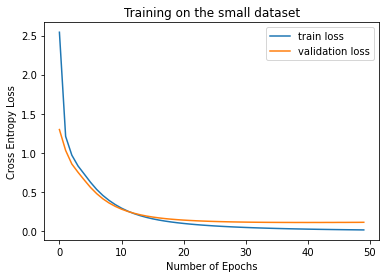

In [72]:
n_total_batches = len(train_eval_loss_batch)

plt.plot(train_eval_loss_epoch, label="train loss")
plt.plot(val_eval_loss_epoch, label="validation loss")

plt.xlabel("Number of Epochs")
plt.ylabel("Cross Entropy Loss")

plt.title("Training on the " + training_file[:-10] + " dataset")
plt.legend()
#plt.savefig("Plot_training_" + training_file[:-10] + "_dataset")
plt.show